In [1]:
using Distributed
addprocs(44);

In [ ]:
using pulse_input_DDM

┌ Info: Precompiling pulse_input_DDM [c2542da2-1f7d-11e9-2506-87691095ebb2]
└ @ Base loading.jl:1278


In [3]:
path = "/usr/people/briandd/Projects/neural_DDM_analysis/data/hanks_data_sessions"

"/usr/people/briandd/Projects/neural_DDM_analysis/data/hanks_data_sessions"

In [4]:
#ratnames = ["B068","T034","T036","T063","T030"] #FOF
#ratnames = ["T035","T011","B053"] PPC
#ratnames = ["T080","T103","E021"] #STR

In [5]:
region, rat = "FOF", "T036"

("FOF", "T036")

In [6]:
sessions = filter(x->occursin(rat,x), readdir(path))

12-element Array{String,1}:
 "T036_154154.mat"
 "T036_154291.mat"
 "T036_154448.mat"
 "T036_154991.mat"
 "T036_155124.mat"
 "T036_155247.mat"
 "T036_155840.mat"
 "T036_157201.mat"
 "T036_157357.mat"
 "T036_157507.mat"
 "T036_168499.mat"
 "T036_168627.mat"

In [7]:
output = load.(joinpath.(path, sessions[end-2:end]), false, delay=0.05);

In [8]:
data = getindex.(output, 1);

In [9]:
θy = Sigmoid(10.,60.,0.3,1.)

Sigmoid{Float64}
  a: Float64 10.0
  b: Float64 60.0
  c: Float64 0.3
  d: Float64 1.0


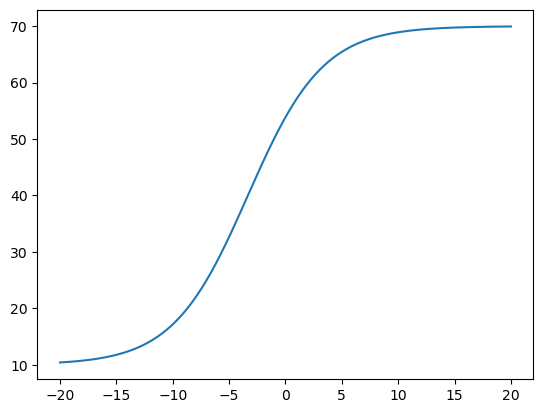

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd6fed3be10>

In [10]:
using PyPlot
plot(collect(-20.:0.1:20.), θy.(collect(-20.:0.1:20.), 0.))

In [11]:
f, ncells, ntrials, nparams = "Softplus", map(x-> x[1].ncells, data), length.(data), 3

θ_syn = θneural(θz = θz(σ2_i = 0.5, B = 40., λ = -0.5, σ2_a = 50., σ2_s = 0.1,
    ϕ = 0.6, τ_ϕ =  0.02),
    θy=[[Softplus(10., rand([-1.,1.]),0.) for n in 1:N] for N in ncells], ncells=ncells,
    nparams=nparams, f=f)

θneural{θz{Float64},Array{Array{Softplus{Float64},1},1}}
  θz: θz{Float64}
  θy: Array{Array{Softplus{Float64},1}}((3,))
  ncells: Array{Int64}((3,)) [3, 3, 4]
  nparams: Int64 3
  f: String "Softplus"


In [12]:
f, ncells, ntrials, nparams = "Sigmoid", map(x-> x[1].ncells, data), length.(data), 4

θ_syn = θneural(θz = θz(σ2_i = 0.5, B = 20., λ = -0.5, σ2_a = 10., σ2_s = 0.1,
    ϕ = 0.6, τ_ϕ =  0.02),
    θy=[[Sigmoid(10., 60., 0.3*rand([-1,1]), rand([-1.,1.])) for n in 1:N] for N in ncells], ncells=ncells,
    nparams=nparams, f=f)

θneural{θz{Float64},Array{Array{Sigmoid{Float64},1},1}}
  θz: θz{Float64}
  θy: Array{Array{Sigmoid{Float64},1}}((3,))
  ncells: Array{Int64}((3,)) [3, 3, 4]
  nparams: Int64 4
  f: String "Sigmoid"


In [13]:
ntrials

3-element Array{Int64,1}:
 389
 339
 431

In [13]:
f, ncells, ntrials, nparams = "Sigmoid", [2], [5_000], 4

θ_syn = θneural(θz = θz(σ2_i = 0.5, B = 20., λ = -0.5, σ2_a = 10., σ2_s = 0.1,
    ϕ = 0.6, τ_ϕ =  0.02),
    θy=[[Sigmoid(10., 60., 0.3*rand([-1,1]), rand([-1.,1.])) for n in 1:N] for N in ncells], ncells=ncells,
    nparams=nparams, f=f)

θneural{θz{Float64},Array{Array{Sigmoid{Float64},1},1}}
  θz: θz{Float64}
  θy: Array{Array{Sigmoid{Float64},1}}((1,))
  ncells: Array{Int64}((1,)) [2]
  nparams: Int64 4
  f: String "Sigmoid"


In [ ]:
f, ncells, ntrials, nparams = "Sigmoid", [5,4,2], [300,400,500], 4

θ_syn = θneural(θz = θz(σ2_i = 0.5, B = 20., λ = -0.5, σ2_a = 10., σ2_s = 0.1,
    ϕ = 0.6, τ_ϕ =  0.02),
    θy=[[Sigmoid(10., 60., 0.3*rand([-1,1]), rand([-1.,1.])) for n in 1:N] for N in ncells], ncells=ncells,
    nparams=nparams, f=f)

In [14]:
data, μ_rnt, μ_t = synthetic_data(θ_syn, ntrials; centered=true, pos_ramp=true);

In [15]:
output = pulse_input_DDM.process_spike_data.(μ_rnt, data, ncells; nconds=2);

In [16]:
μ_ct = getindex.(output, 1)
σ_ct = getindex.(output, 2);

In [17]:
_, μ_c_λ = pulse_input_DDM.synthetic_λ(θ_syn, data; num_samples=100, nconds=2);

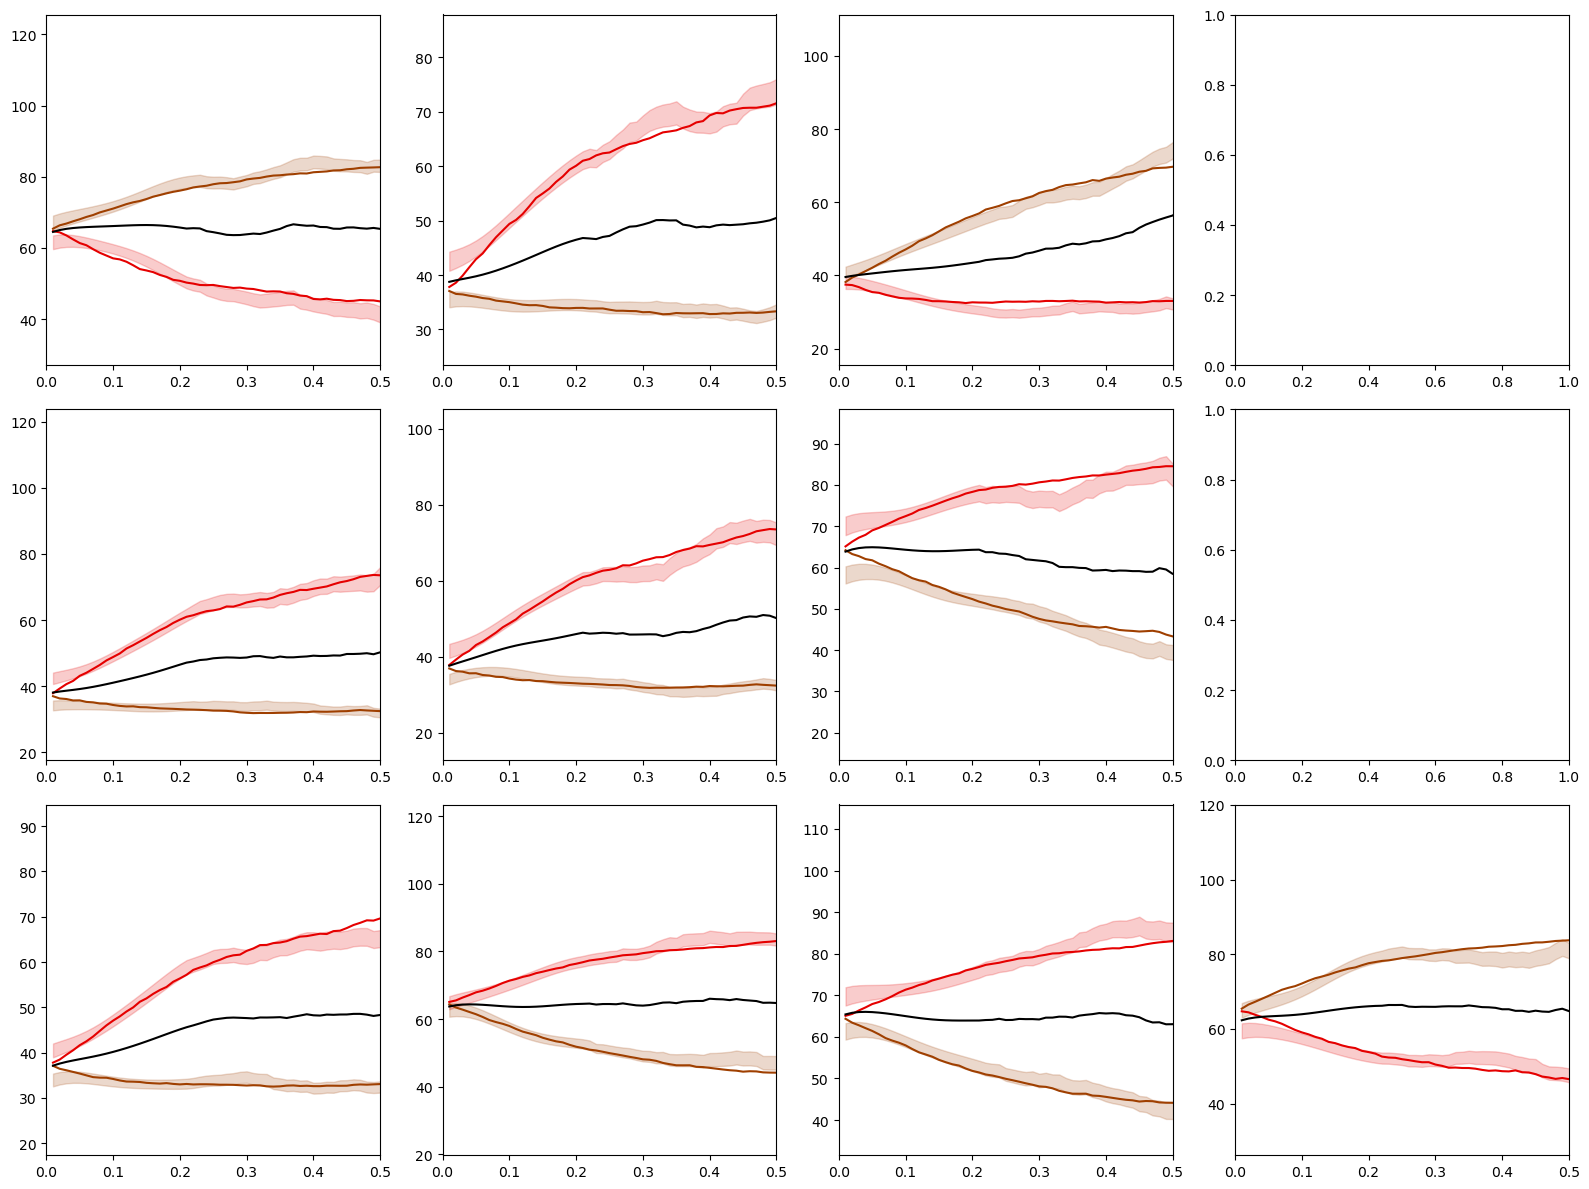

In [18]:
using PyPlot

dt = 1e-2

num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]

for i in 1:num_rows
        
    for j in 1:data[i][1].ncells             
        for k = 1:2     

            ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                μ_ct[i][j][k] + σ_ct[i][j][k],
                μ_ct[i][j][k] - σ_ct[i][j][k],
                alpha=0.2, color=my_colors[k])

            ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                μ_c_λ[i][j][k], color=my_colors[k])                                     

            ax[i,j].set_xlim((0, 0.5))
                        
        end   
        
        ax[i,j].plot((1:length(μ_t[i][j]))*dt,
            μ_t[i][j], color="black")

    end
    
end

tight_layout() 

In [19]:
θy0 = vcat(vcat(initialize_θy.(data, f)...)...);

In [20]:
options = Sigmoidoptions(ncells=ncells, 
    x0=vcat([0.1, 12., -2., 10., 0.1, 0.8, 0.008], θy0),
    fit=vcat(trues(dimz), trues(sum(ncells)*nparams)), nparams=nparams, f=f)

Sigmoidoptions
  ncells: Array{Int64}((3,)) [3, 3, 4]
  nparams: Int64 4
  f: String "Sigmoid"
  fit: Array{Bool}((47,)) Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  lb: Array{Float64}((47,)) [0.0, 8.0, -5.0, 0.0, 0.0, 0.01, 0.005, 2.220446049250313e-16, 2.220446049250313e-16, -Inf  …  -Inf, -Inf, 2.220446049250313e-16, 2.220446049250313e-16, -Inf, -Inf, 2.220446049250313e-16, 2.220446049250313e-16, -Inf, -Inf]
  ub: Array{Float64}((47,)) [30.0, 32.0, 5.0, 200.0, 5.0, 1.2, 1.0, Inf, Inf, Inf  …  Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf]
  x0: Array{Float64}((47,)) [0.1, 12.0, -2.0, 10.0, 0.1, 0.8, 0.008, 30.263157894736842, 61.21381404809005, 0.012630371732181468  …  -0.01250466459136637, 0.0, 30.8252427184466, 61.294832328457716, -0.01298843477851428, 0.0, 32.270168855534706, 56.443423377475, 0.011687641542365042, 0.0]


In [21]:
n = 53
loglikelihood(θ_syn, data, n)

-227328.71426440927

In [22]:
model, = optimize(data, options, n)

Fminbox
-------
Initial mu = 0.198294

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.198294

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     2.418511e+05     6.396033e+03
 * time: 0.00022912025451660156
     1     2.416837e+05     6.405255e+03
 * time: 8.412772178649902
     2     2.356180e+05     1.376565e+04
 * time: 16.708860158920288
     3     2.341647e+05     9.064675e+02
 * time: 25.699169158935547
     4     2.337076e+05     5.353140e+02
 * time: 35.1470160484314
     5     2.331974e+05     6.255343e+02
 * time: 44.06067514419556
     6     2.330440e+05     8.767672e+02
 * time: 52.69135904312134
     7     2.330240e+05     9.149798e+02
 * time: 60.77843403816223
     8     2.330131e+05     9.374502e+02
 * time: 68.8445360660553
     9     2.328090e+05     2.414366e+03
 * time: 77.02155709266663
    10     2.327800e+05     2.452338e+03
 * time: 85.49321508407593
    11     2.327495e+05     2.449857e+

   117     2.282780e+05     2.610090e+02
 * time: 1245.9627420902252
   118     2.282682e+05     2.663152e+02
 * time: 1259.0378711223602
   119     2.282646e+05     2.589180e+02
 * time: 1277.1146790981293
   120     2.282605e+05     2.347843e+02
 * time: 1285.098857164383
   121     2.282563e+05     2.415238e+02
 * time: 1292.8786940574646
   122     2.282545e+05     2.454532e+02
 * time: 1300.7410190105438
   123     2.282520e+05     2.297296e+02
 * time: 1308.336739063263
   124     2.282405e+05     2.054960e+02
 * time: 1316.082937002182
   125     2.282399e+05     3.714172e+02
 * time: 1327.6541891098022
   126     2.282387e+05     4.783456e+02
 * time: 1343.3505020141602
   127     2.282374e+05     7.332452e+02
 * time: 1358.957720041275
   128     2.282354e+05     3.339946e+02
 * time: 1370.588147163391
   129     2.282344e+05     1.158169e+02
 * time: 1382.0936901569366
   130     2.282335e+05     7.563269e+01
 * time: 1393.5932731628418
   131     2.282332e+05     1.761606e+0

   237     2.273120e+05     2.688792e+02
 * time: 2687.586791038513
   238     2.273054e+05     1.852271e+02
 * time: 2699.3537311553955
   239     2.272901e+05     1.414074e+03
 * time: 2707.240445137024
   240     2.272885e+05     2.155033e+03
 * time: 2715.250899076462
   241     2.272875e+05     2.588628e+03
 * time: 2726.9902811050415
   242     2.272870e+05     1.931587e+03
 * time: 2734.9414551258087
   243     2.272764e+05     1.400093e+03
 * time: 2743.0895521640778
   244     2.272728e+05     5.802555e+01
 * time: 2751.1345880031586
   245     2.272717e+05     1.305391e+02
 * time: 2758.9208810329437
   246     2.272713e+05     3.292505e+02
 * time: 2767.0644330978394
   247     2.272710e+05     7.203192e+01
 * time: 2775.1225860118866
   248     2.272709e+05     1.342246e+01
 * time: 2783.188588142395
   249     2.272709e+05     1.647594e+01
 * time: 2791.2302861213684
   250     2.272709e+05     1.593792e+01
 * time: 2799.568583011627
   251     2.272708e+05     1.606133e+0

optimization complete. converged: true 



(neuralDDM{θneural{θz{Float64},Array{Array{Sigmoid{Float64},1},1}},Array{Array{neuraldata,1},1}}
  θ: θneural{θz{Float64},Array{Array{Sigmoid{Float64},1},1}}
  data: Array{Array{neuraldata,1}}((3,))
,  * Status: success

 * Candidate solution
    Minimizer: [4.11e-01, 1.64e+01, -2.01e-01,  ...]
    Minimum:   2.272851e+05

 * Found with
    Algorithm:     Fminbox with BFGS
    Initial Point: [1.00e-01, 1.20e+01, -2.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.84e-04 ≰ 1.0e-10
    |x - x'|/|x'|          = 1.46e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.16e-04 ≰ 1.0e-09
    |f(x) - f(x')|/|f(x')| = 5.09e-10 ≰ 0.0e+00
    |g(x)|                 = 3.46e-01 ≰ 1.0e-03

 * Work counters
    Seconds run:   3448  (vs limit Inf)
    Iterations:    4
    f(x) calls:    6137
    ∇f(x) calls:   1177
)

In [26]:
hcat(collect(pulse_input_DDM.flatten(model.θ)), collect(pulse_input_DDM.flatten(θ_syn)))

47×2 Array{Float64,2}:
  0.411219    0.5 
 16.3905     20.0 
 -0.20088    -0.5 
  4.55322    10.0 
  0.0728642   0.1 
  0.59927     0.6 
  0.0182756   0.02
  8.55041    10.0 
 61.7268     60.0 
  0.296098    0.3 
  1.12791     1.0 
 10.0246     10.0 
 57.0203     60.0 
  ⋮               
 10.9526     10.0 
 58.2019     60.0 
 -0.29401    -0.3 
  1.15592     1.0 
  6.95892    10.0 
 64.5719     60.0 
 -0.250531   -0.3 
  1.00768     1.0 
  9.82355    10.0 
 59.3339     60.0 
  0.269285    0.3 
  0.98598     1.0 

In [27]:
μ_λ, μ_c_λ = pulse_input_DDM.synthetic_λ(model.θ, data; num_samples=100, nconds=2);

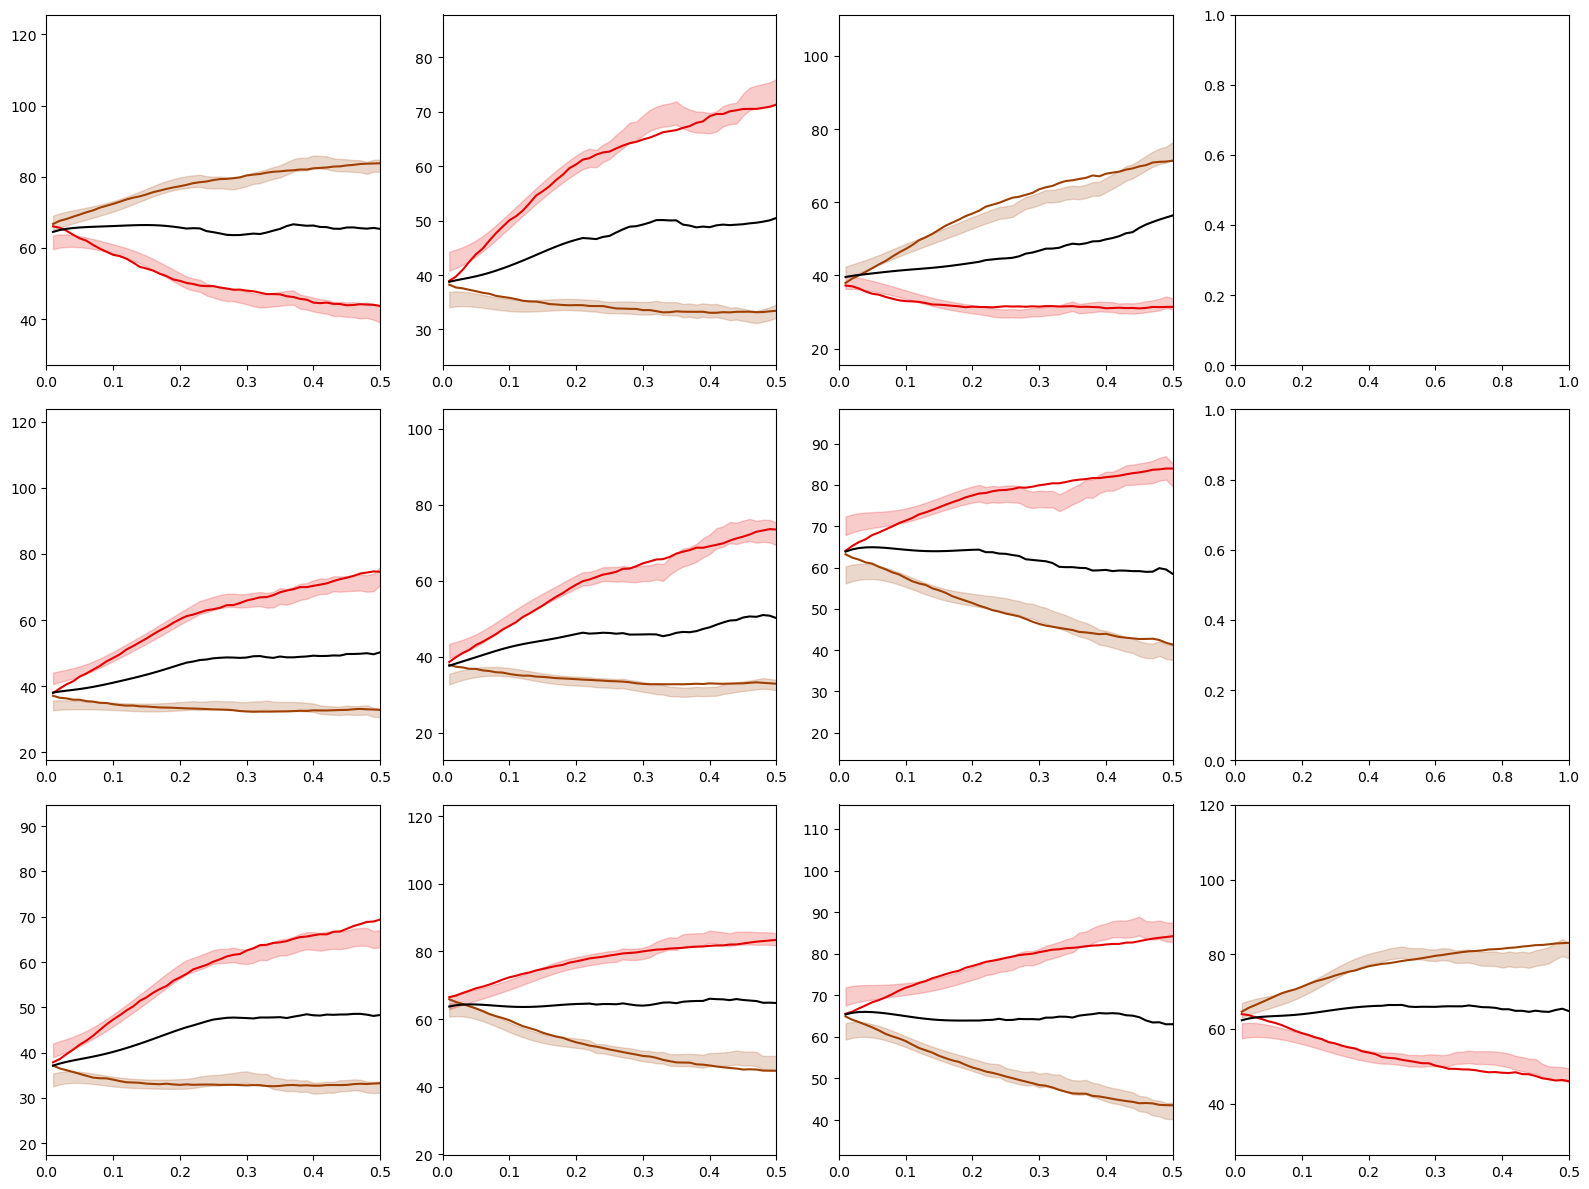

In [28]:
num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]

for i in 1:num_rows
        
    for j in 1:data[i][1].ncells             
        for k = 1:2     

            ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                μ_ct[i][j][k] + σ_ct[i][j][k],
                μ_ct[i][j][k] - σ_ct[i][j][k],
                alpha=0.2, color=my_colors[k])

            ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                μ_c_λ[i][j][k], color=my_colors[k])                                     

            ax[i,j].set_xlim((0, 0.5))
                        
        end   
        
        ax[i,j].plot((1:length(μ_t[i][j]))*dt,
            μ_t[i][j], color="black")

    end
    
end

tight_layout() 

In [29]:
H = Hessian(model, n)
CI, HPSD = CIs(H);

In [ ]:
CI

In [ ]:
hcat(collect(pulse_input_DDM.flatten(model.θ)) - CI, collect(pulse_input_DDM.flatten(θ_syn)), collect(pulse_input_DDM.flatten(model.θ)) + CI)

In [ ]:
hcat(collect(pulse_input_DDM.flatten(model.θ)) - CI .< 
    collect(pulse_input_DDM.flatten(θ_syn)) .< 
    collect(pulse_input_DDM.flatten(model.θ)) + CI)